In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling1D

from transformer.encoder import Encoder
from transformer.utils import WordTokenizer

In [2]:
config = {'num_heads': 12, 
          'vocab_size': 30522,
          'hidden_size': 128,
          'max_position_embeds': 512,
          'intermediate_size': 512,
          'dropout_p': 0.1,
          'input_size': 100,
          'num_hidden_layers': 1}

## Get some toy data

The yelp sentence sentiment data set from Kaggle will do

In [3]:
rows = []
with open('yelp_labelled.txt', 'r') as FILE:
    while True:
        row = FILE.readline()
        if not row:
            break
        row = row.strip().split('\t')
        sentence = row[0]
        sentiment = int(row[1])
        rows.append({'sentence': sentence, 'sentiment': sentiment})
 
df = pd.DataFrame(rows, columns=['sentence', 'sentiment'])
df.head()

,sentence,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1


### Tokenize the sentences and split into x and y 

y will be the last token of each sequence, so we can try to predict it. But mostly we just want to see if our transformer encoder trains.

In [24]:
tokenizer = WordTokenizer(make_mask=True)
config['vocab_size'] = tokenizer.fit(df['sentence'].values)
tokens, masks = tokenizer.transform(df['sentence'].values,
                             max_len=config['input_size'])

X = np.array([s[:-1] for s in tokens])
y = np.array([s[-1] for s in tokens])
masks = np.array(masks[:, :-1])

print(f'Number of sentences: {df.shape[0]}')
print(f'Vocabulary size: {config["vocab_size"]}')

Number of sentences: 1000
Vocabulary size: 2971


## Try our transformer!

We'll just train our encoder by the task of predicting the last word of each sentence

In [27]:
token_input = Input(shape=(config['input_size'] - 1,))
mask_input = Input(shape=(config['input_size'] - 1,))
x = Encoder(config)([token_input, mask_input])
x = GlobalAveragePooling1D()(x)
output = Dense(config['vocab_size'], activation='softmax')(x)

clf = Model(inputs=[token_input, mask_input], outputs=output)

clf.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 99)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 99)]         0           []                               
                                                                                                  
 Encoder (Encoder)              (None, 99, 128)      640232      ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 global_average_pooling1d_4 (Gl  (None, 128)         0           ['Encoder[0][0]']          

In [29]:
clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
hist = clf.fit([X, masks],
               y,
               epochs=100)

Epoch 1/100
32/32 [==============================] - 20s 155ms/step - loss: 2.0107
Epoch 2/100
32/32 [==============================] - 5s 158ms/step - loss: 1.1094
Epoch 3/100
32/32 [==============================] - 5s 154ms/step - loss: 0.6771
Epoch 4/100
32/32 [==============================] - 5s 158ms/step - loss: 0.4675
Epoch 5/100
32/32 [==============================] - 5s 153ms/step - loss: 0.4020
Epoch 6/100
32/32 [==============================] - 5s 155ms/step - loss: 0.3178
Epoch 7/100
32/32 [==============================] - 5s 153ms/step - loss: 0.2863
Epoch 8/100
32/32 [==============================] - 5s 154ms/step - loss: 0.1978
Epoch 9/100
32/32 [==============================] - 5s 153ms/step - loss: 0.2552
Epoch 10/100
32/32 [==============================] - 5s 158ms/step - loss: 0.2517
Epoch 11/100
32/32 [==============================] - 5s 153ms/step - loss: 0.2276
Epoch 12/100
32/32 [==============================] - 5s 157ms/step - loss: 0.2037
Epoch 13/100

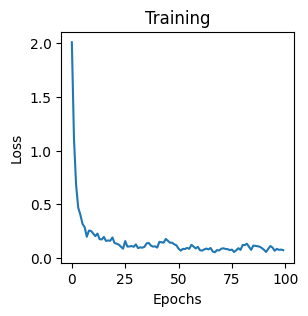

In [30]:
plt.figure(figsize=(3,3))
plt.plot(hist.history['loss'])
plt.title('Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


## Test our toy model

Make up a few sentences that may belong to the distribution (Yelp restaraunt review sentences).

Then, dropping off that last word of each, try to complete them. 


In [31]:
s = ["It really tasted awful.",
     "It was very good.",
     "It was awful.",
     "This is a very bad place.",
     "The spaghetti was perfect",
     "The eggs were gross!",
     "My steak was bad."]

# Tokenize our sentence, separate last word, and pad
tokens, masks = tokenizer.transform(s,
                             max_len=config['input_size'])

X_test = np.array([s[:-1] for s in tokens])
y_test = np.array([s[-1] for s in tokens])
masks_test = np.array(masks[:, :-1])

# Predict last word
y_hat = clf.predict([X_test, masks_test])
y_hat = np.argmax(y_hat, axis=1)

for i in range(len(s)):
     # construct predicted complete sentence
     pred_s = X_test[i].tolist()
     pred_s.append(y_hat[i])

     #unpad
     pred_s = [token for token in pred_s if token!= 0]
     pred_s = ' '.join([tokenizer.vocab_reverse[i] for i in pred_s])
     print(f'\nOriginal sentence: {s[i]}\nCompleted sentence: {pred_s}')




1/1 [==============================] - 2s 2s/step

Original sentence: It really tasted awful.
Completed sentence: It really tasted though!

Original sentence: It was very good.
Completed sentence: It was very good.

Original sentence: It was awful.
Completed sentence: It was delicious!!!

Original sentence: This is a very bad place.
Completed sentence: This is a very bad Experience!

Original sentence: The spaghetti was perfect
Completed sentence: The spaghetti was amazing.

Original sentence: The eggs were gross!
Completed sentence: The eggs were amazing

Original sentence: My steak was bad.
Completed sentence: My steak was terrible!


## Save encoder model

Omitting the classifier head

In [32]:
encoder_model = tf.keras.models.Model(inputs=clf.layers[0].input,
                                      outputs=clf.layers[-2].output)
encoder_model.summary()

ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, 99), dtype=tf.float32, name='input_10'), name='input_10', description="created by layer 'input_10'") at layer "Encoder". The following previous layers were accessed without issue: []

In [15]:
encoder_model.save('encoder_model.h5')